## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.set_style("whitegrid")
sns.set_palette("pastel")

from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [2]:
fasttext = {
    "en": KeyedVectors.load_word2vec_format("../../fasttext/wiki.en.align.vec", binary=False),
    "ko": KeyedVectors.load_word2vec_format("../../fasttext/wiki.ko.align.vec", binary=False),
}

In [18]:
df = pd.read_csv('../../data/embedding_preprocessed_data.csv')
df.head()

,Comment,Sentiment,Language
0,"['맛있', '분위기', '좋', '어요', '야외', '에서', '식사', '가능...",1,ko
1,"['어느', '수산', '시장', '에서', '나', '나오', '면', '먹', ...",0,ko
2,"['wow', 'wow', 'funky', 'little', 'fleet', 'sa...",1,en
3,"['invention', 'original', 'purpose', 'british'...",1,en
4,"['양', '푸짐', '소스', '모자라', '면', '리필', '가능', '어서'...",1,ko


In [19]:
df_copy = df.copy()

### Embed Texts

In [20]:
def create_vector(tokens, lang):
    model = fasttext[lang]
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [21]:
def vectorize_and_split(df, test_size, lang):
    X = df[["Comment", "Language"]]
    y = df["Sentiment"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    for X_part in [X_train, X_test]:
        X_part["embedding"] = X_part.apply(
            lambda row: create_vector(row["Comment"], row["Language"]), axis=1
        )

    X_train_emb = np.stack(X_train["embedding"].values)
    X_test_emb = np.stack(X_test["embedding"].values)

    np.save(f"../../model/{lang}_fasttext_train_embeddings.npy", X_train_emb)
    np.save(f"../../model/{lang}_fasttext_test_embeddings.npy", X_test_emb)
    np.savez(
        f"../../model/{lang}_train_test_labels.npz",
        y_train=y_train.to_numpy(),
        y_test=y_test.to_numpy(),
    )

    return X_train_emb, X_test_emb, y_train, y_test

### Train and Evaluate

In [22]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    print(f"{'-' * 40}{model_name}{'-' * 40}")
    model.fit(X_train, y_train)

    results = []
    for mode, X, y in [("Test", X_test, y_test), ("Train", X_train, y_train)]:
        y_pred = model.predict(X)
        print(f"\n{mode} Classification Report:\n")
        print(classification_report(y, y_pred))

        ConfusionMatrixDisplay.from_estimator(
            model, X, y, display_labels=["Negative", "Positive"], cmap="Blues"
        )
        plt.title(f"{model_name} Confusion Matrix ({mode} Set)")
        plt.show()

        report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        acc = accuracy_score(y, y_pred)
        results.append(
            {
                "Model": model_name,
                "Dataset": mode,
                "Accuracy": acc,
                "Precision": report["weighted avg"]["precision"],
                "Recall": report["weighted avg"]["recall"],
                "F1-Score": report["weighted avg"]["f1-score"],
            }
        )

    return results

In [23]:
def run_all_models(X_train, X_test, y_train, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM": LinearSVC(),
    }
    all_results = []
    for name, model in models.items():
        results = train_and_evaluate(model, X_train, X_test, y_train, y_test, name)
        all_results.extend(results)
    return all_results

In [24]:
def train_models(df, language):
    print(f"\n{'-' * 40}{language}{'-' * 40}")
    lang_map = {"English + Korean": "both", "Korean": "ko", "English": "en"}
    X_train, X_test, y_train, y_test = vectorize_and_split(df, 0.2, lang_map[language])
    results = run_all_models(X_train, X_test, y_train, y_test)
    for r in results:
        r["Language"] = language
    return pd.DataFrame(results) 

### English + Korean


----------------------------------------English + Korean----------------------------------------
----------------------------------------Logistic Regression----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.70      0.69     20063
           1       0.69      0.68      0.68     19937

    accuracy                           0.69     40000
   macro avg       0.69      0.69      0.69     40000
weighted avg       0.69      0.69      0.69     40000



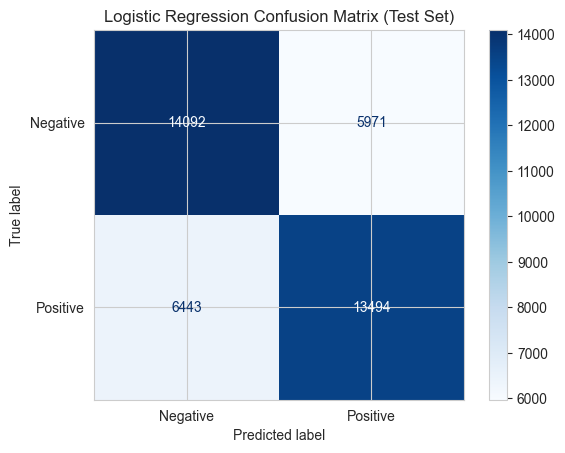


Train Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     79937
           1       0.70      0.67      0.68     80063

    accuracy                           0.69    160000
   macro avg       0.69      0.69      0.69    160000
weighted avg       0.69      0.69      0.69    160000



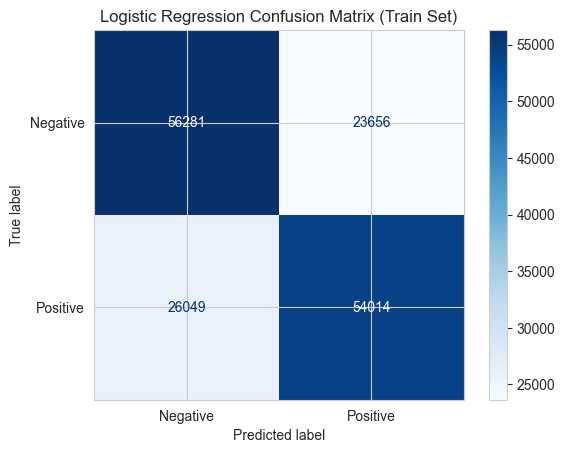

----------------------------------------SVM----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.74      0.73     20063
           1       0.73      0.71      0.72     19937

    accuracy                           0.72     40000
   macro avg       0.72      0.72      0.72     40000
weighted avg       0.72      0.72      0.72     40000



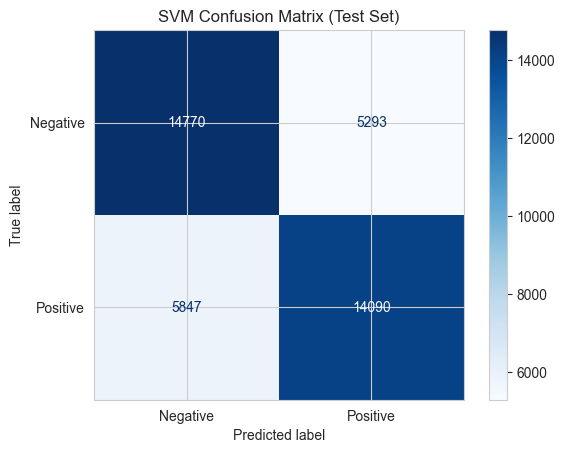


Train Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.74      0.73     79937
           1       0.73      0.70      0.72     80063

    accuracy                           0.72    160000
   macro avg       0.72      0.72      0.72    160000
weighted avg       0.72      0.72      0.72    160000



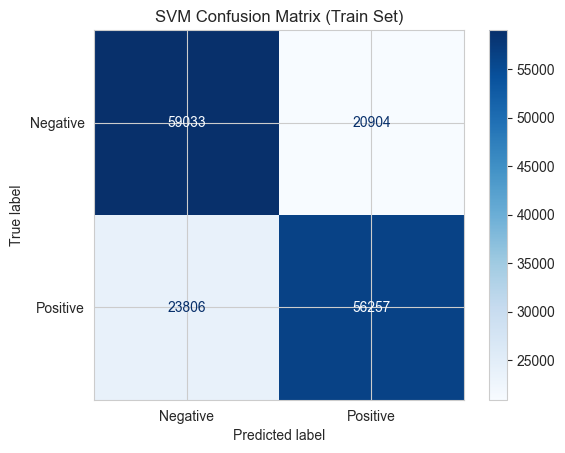

In [25]:
results_all = train_models(df, "English + Korean")

### Korean Only


----------------------------------------Korean----------------------------------------
----------------------------------------Logistic Regression----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     10108
           1       0.79      0.80      0.80      9892

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



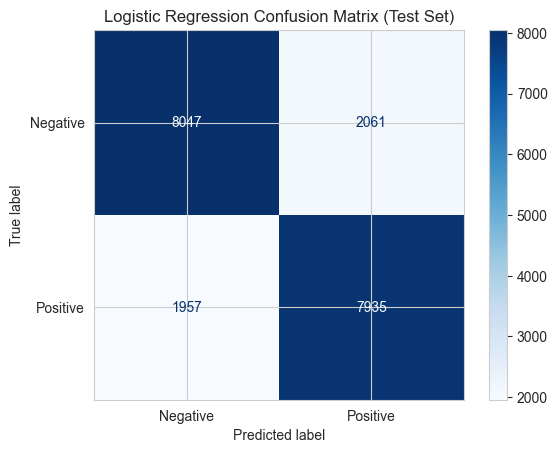


Train Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     39892
           1       0.80      0.80      0.80     40108

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



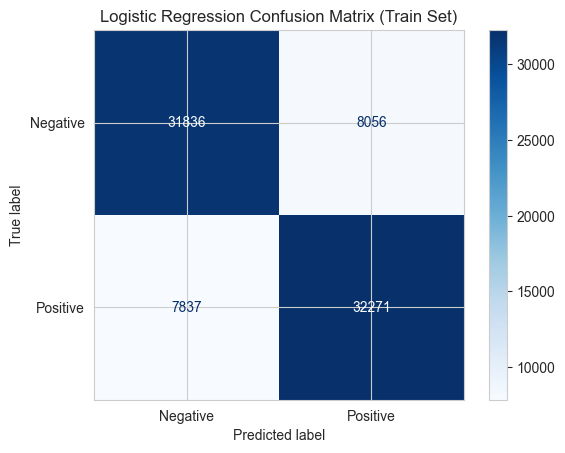

----------------------------------------SVM----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10108
           1       0.85      0.85      0.85      9892

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



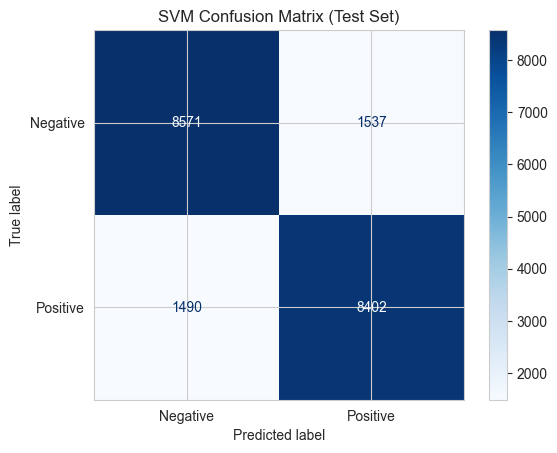


Train Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     39892
           1       0.85      0.85      0.85     40108

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000



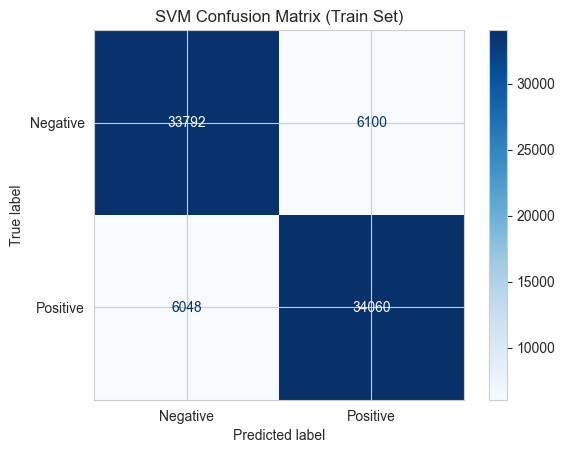

In [27]:
results_ko = train_models(df_copy[df_copy["Language"] == "ko"], "Korean")

### English Only


----------------------------------------English----------------------------------------
----------------------------------------Logistic Regression----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.61      0.60     10035
           1       0.59      0.56      0.58      9965

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000



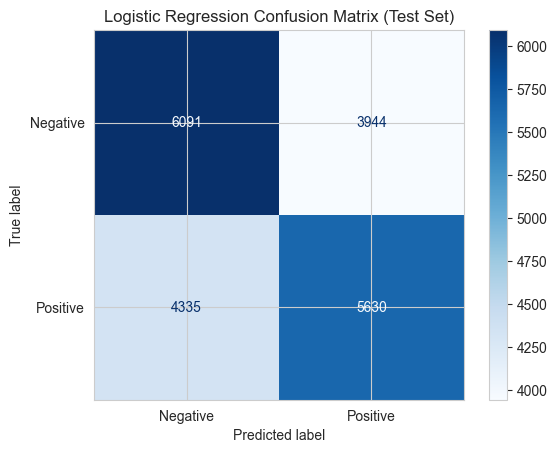


Train Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.61      0.59     39965
           1       0.59      0.56      0.58     40035

    accuracy                           0.59     80000
   macro avg       0.59      0.59      0.58     80000
weighted avg       0.59      0.59      0.58     80000



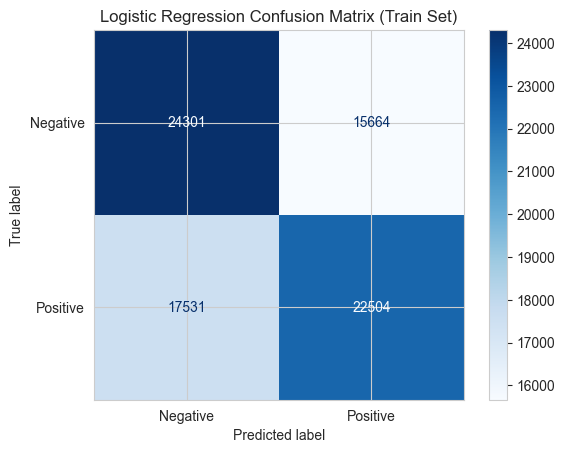

----------------------------------------SVM----------------------------------------

Test Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.64      0.61     10035
           1       0.60      0.56      0.58      9965

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



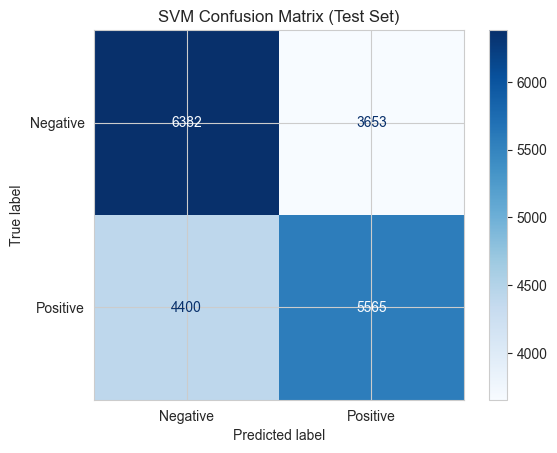


Train Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.64      0.61     39965
           1       0.61      0.56      0.58     40035

    accuracy                           0.60     80000
   macro avg       0.60      0.60      0.60     80000
weighted avg       0.60      0.60      0.60     80000



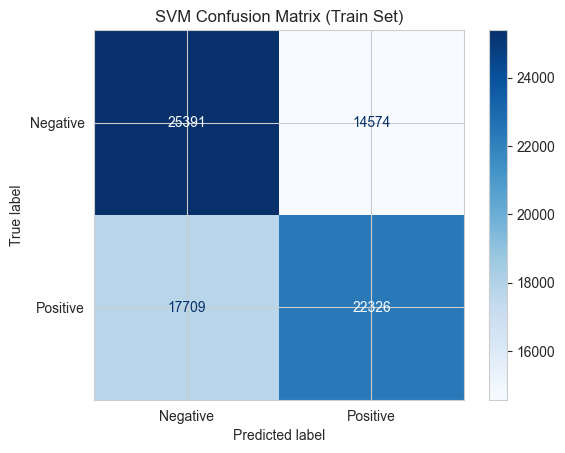

In [26]:
results_en = train_models(df_copy[df_copy["Language"] == "en"], "English")

## Comparing

In [26]:
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_colwidth", None)

all_results_df = pd.concat([results_all, results_en, results_ko], ignore_index=True)
print("FINAL COMPARISON SUMMARY")
print(tabulate(all_results_df.reset_index(drop=True), headers="keys", tablefmt="psql"))

FINAL COMPARISON SUMMARY
+----+---------------------+-----------+------------+-------------+----------+------------+------------------+
|    | Model               | Dataset   |   Accuracy |   Precision |   Recall |   F1-Score | Language         |
|----+---------------------+-----------+------------+-------------+----------+------------+------------------|
|  0 | Logistic Regression | Test      |   0.68965  |    0.689733 | 0.68965  |   0.689595 | English + Korean |
|  1 | Logistic Regression | Train     |   0.689344 |    0.689521 | 0.689344 |   0.689278 | English + Korean |
|  2 | SVM                 | Test      |   0.7215   |    0.721646 | 0.7215   |   0.721434 | English + Korean |
|  3 | SVM                 | Train     |   0.720562 |    0.720861 | 0.720562 |   0.720475 | English + Korean |
|  4 | Logistic Regression | Test      |   0.58605  |    0.586125 | 0.58605  |   0.585863 | English          |
|  5 | Logistic Regression | Train     |   0.585063 |    0.585265 | 0.585063 |   0.5848

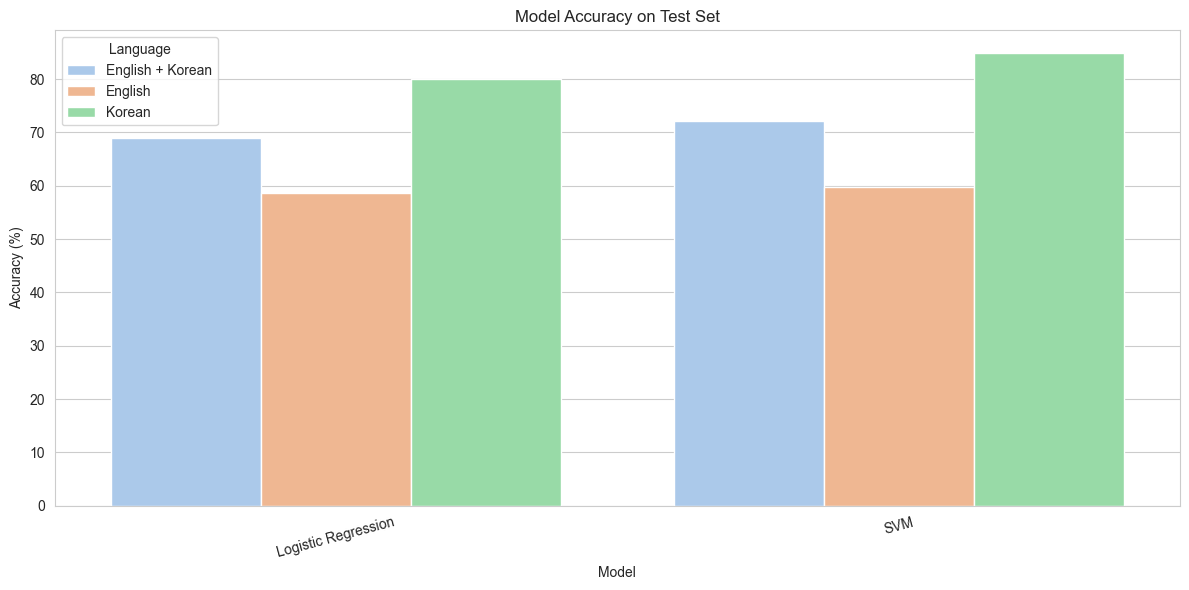

In [27]:
plt.figure(figsize=(12, 6))
subset = all_results_df[all_results_df["Dataset"] == "Test"].copy()
subset["Accuracy_percent"] = subset["Accuracy"] * 100

sns.barplot(
    data=subset,
    x="Model",
    y="Accuracy_percent",
    hue="Language",
)
plt.title("Model Accuracy on Test Set")
plt.ylabel("Accuracy (%)")
plt.legend(title="Language")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()